In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import statistics
import random

# Load predictor

In [2]:
predictor = xgb.XGBClassifier()
predictor.load_model("predictor.json")
predictor

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              feature_types=['int', 'int', 'float', 'float', 'float', 'float',
                             'int', 'float'],
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [3]:
processed_data = pd.read_csv("preprocessed_data.csv")
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454282 entries, 0 to 454281
Data columns (total 26 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unnamed: 0                       454282 non-null  int64  
 1   courier_id                       454282 non-null  int64  
 2   dispatch_time                    454282 non-null  object 
 3   grab_time                        454282 non-null  object 
 4   dt                               454282 non-null  object 
 5   order_id                         454282 non-null  int64  
 6   waybill_id                       454282 non-null  int64  
 7   da_id                            454282 non-null  int64  
 8   is_courier_grabbed               454282 non-null  int64  
 9   is_weekend                       454282 non-null  int64  
 10  is_prebook                       454282 non-null  int64  
 11  dispatch_to_meal_ready_duration  454282 non-null  float64
 12  me

In [4]:
features = ["dispatch_time_of_day", 
            "courier_area_count", "reject_rate_in_last_hour",
            "var_meal_prepare_duration", 
            "dispatch_to_meal_ready_duration", 
            "assigned_to_deadline_duration", 
            "batch_size", "batch_distance"]

df = processed_data
X = df[features]
y = df["is_courier_grabbed"]

In [5]:
predictor.score(X, y)

0.903143862182521

# Model the problem

### Decision point
$$
\text{Every 1 minute: $T = \{1, 2, \ldots, 1440\}$}
$$

### State
$$
\text{Orders $O_t$ and Couriers $C_t$ information in every period.}
$$

### Decisions

$$
y_{i,k,t} \in {0, 1}
$$


$$
\text{s.t.}\sum_{k \in C_t} y_{i,k,t} = 1 \quad \forall i \in O_t, \, t \in T
$$

### Reward

$$
r_t = \frac{\sum_{i \in O_t} \sum_{j \in \text{unique\(C_t\)}} \zeta_\text{proba}(\tau(y_{i,j,t}) \rightarrow features)}{\text{all assignments}} \in [0, 1]
$$

### Post-decision state
$$
\text{Orders $O_t$ and Couriers $C_t$ information after decision. Rejected orders go through transition to the next period.}
$$

### Objective

$$
\text{Max Z} = \sum_{t \in T} r_t
$$

# Prepare data for optimization

In [6]:
opt_data = pd.read_csv("data_for_optimization.csv")
opt_data["dispatch_time"] = pd.to_datetime(opt_data["dispatch_time"])
opt_data["grab_time"] = pd.to_datetime(opt_data["grab_time"])
opt_data["arrive_time"] = pd.to_datetime(opt_data["arrive_time"])
opt_data["estimate_meal_prepare_time"] = pd.to_datetime(opt_data["estimate_meal_prepare_time"])
opt_data["order_push_time"] = pd.to_datetime(opt_data["order_push_time"])
opt_data["platform_order_time"] = pd.to_datetime(opt_data["platform_order_time"])
opt_data["estimate_arrived_time"] = pd.to_datetime(opt_data["estimate_arrived_time"])
opt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491095 entries, 0 to 491094
Data columns (total 35 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Unnamed: 0                       491095 non-null  int64         
 1   dt                               491095 non-null  object        
 2   order_id                         491095 non-null  int64         
 3   waybill_id                       491095 non-null  int64         
 4   courier_id                       491095 non-null  int64         
 5   da_id                            491095 non-null  int64         
 6   is_courier_grabbed               491095 non-null  int64         
 7   is_weekend                       491095 non-null  int64         
 8   estimate_arrived_time            491095 non-null  datetime64[ns]
 9   is_prebook                       491095 non-null  int64         
 10  poi_id                           491095 non-

In [7]:
opt_data['dispatch_minute'] = opt_data['dispatch_time'].dt.floor('T')

early_orders = opt_data.loc[opt_data.groupby('order_id')['dispatch_time'].idxmin()]

orders_dataset = opt_data[['dispatch_minute', 'order_id', 'waybill_id', 
                               'da_id', 'poi_id', 'sender_recipient_distance', 
                               'estimate_meal_prepare_time', 'estimate_arrived_time',
                               'mean_meal_prepare_duration', 'var_meal_prepare_duration']]
couriers_dataset = opt_data[['dispatch_minute', 'courier_id', 'courier_area_count']]
assignment_result = opt_data[['dispatch_minute', 'is_courier_grabbed']]

orders_by_minute = orders_dataset.groupby('dispatch_minute').apply(lambda x: x.to_dict(orient='records'))
couriers_by_minute = couriers_dataset.groupby('dispatch_minute').apply(lambda x: x.to_dict(orient='records'))
assignment_result_by_minute = assignment_result.groupby('dispatch_minute').apply(lambda x: x.to_dict(orient='records'))

orders_by_minute_df = pd.DataFrame({'dispatch_minute': orders_by_minute.index, 'orders': orders_by_minute.values})
couriers_by_minute_df = pd.DataFrame({'dispatch_minute': couriers_by_minute.index, 'couriers': couriers_by_minute.values})
assignment_result_by_minute = pd.DataFrame({'dispatch_minute': assignment_result_by_minute.index, 'results': assignment_result_by_minute.values})


orginal_assignments_df = pd.merge(orders_by_minute_df, couriers_by_minute_df, on='dispatch_minute', 
                       how='outer').sort_values(by='dispatch_minute').reset_index(drop=True)
orginal_assignments_df = pd.merge(orginal_assignments_df, assignment_result_by_minute, on='dispatch_minute', 
                       how='outer').sort_values(by='dispatch_minute').reset_index(drop=True)
orginal_assignments_df = orginal_assignments_df[orginal_assignments_df['dispatch_minute'].dt.date == pd.to_datetime('2022-10-17').date()]
orginal_assignments_df

,dispatch_minute,orders,couriers,results
0,2022-10-17 00:01:00,"[{'dispatch_minute': 2022-10-17 00:01:00, 'ord...","[{'dispatch_minute': 2022-10-17 00:01:00, 'cou...","[{'dispatch_minute': 2022-10-17 00:01:00, 'is_..."
1,2022-10-17 00:02:00,"[{'dispatch_minute': 2022-10-17 00:02:00, 'ord...","[{'dispatch_minute': 2022-10-17 00:02:00, 'cou...","[{'dispatch_minute': 2022-10-17 00:02:00, 'is_..."
2,2022-10-17 00:03:00,"[{'dispatch_minute': 2022-10-17 00:03:00, 'ord...","[{'dispatch_minute': 2022-10-17 00:03:00, 'cou...","[{'dispatch_minute': 2022-10-17 00:03:00, 'is_..."
3,2022-10-17 00:05:00,"[{'dispatch_minute': 2022-10-17 00:05:00, 'ord...","[{'dispatch_minute': 2022-10-17 00:05:00, 'cou...","[{'dispatch_minute': 2022-10-17 00:05:00, 'is_..."
4,2022-10-17 00:06:00,"[{'dispatch_minute': 2022-10-17 00:06:00, 'ord...","[{'dispatch_minute': 2022-10-17 00:06:00, 'cou...","[{'dispatch_minute': 2022-10-17 00:06:00, 'is_..."
...,...,...,...,...
1393,2022-10-17 23:55:00,"[{'dispatch_minute': 2022-10-17 23:55:00, 'ord...","[{'dispatch_minute': 2022-10-17 23:55:00, 'cou...","[{'dispatch_minute': 2022-10-17 23:55:00, 'is_..."
1394,2022-10-17 23:56:00,"[{'dispatch_minute': 2022-10-17 23:56:00, 'ord...","[{'dispatch_minute': 2022-10-17 23:56:00, 'cou...","[{'dispatch_minute': 2022-10-17 23:56:00, 'is_..."
1395,2022-10-17 23:57:00,"[{'dispatch_minute': 2022-10-17 23:57:00, 'ord...","[{'dispatch_minute': 2022-10-17 23:57:00, 'cou...","[{'dispatch_minute': 2022-10-17 23:57:00, 'is_..."
1396,2022-10-17 23:58:00,"[{'dispatch_minute': 2022-10-17 23:58:00, 'ord...","[{'dispatch_minute': 2022-10-17 23:58:00, 'cou...","[{'dispatch_minute': 2022-10-17 23:58:00, 'is_..."


In [8]:
total_rewards = 0

for index, row in orginal_assignments_df.iterrows():
    accept_count = 0
    total_count = 0
    for result_dict in row["results"]:
        accept_count += result_dict["is_courier_grabbed"]
        total_count += 1
    
    total_rewards += accept_count / total_count

print(total_rewards)

1282.659221516932


In [9]:
early_orders = opt_data.loc[opt_data.groupby('order_id')['dispatch_time'].idxmin()]

orders_dataset = early_orders[['dispatch_minute', 'order_id', 'waybill_id', 
                               'da_id', 'poi_id', 'sender_recipient_distance', 
                               'estimate_meal_prepare_time', 'estimate_arrived_time',
                               'mean_meal_prepare_duration', 'var_meal_prepare_duration']]

couriers_dataset = opt_data[['dispatch_minute', 'courier_id', 'courier_area_count']]

orders_by_minute = orders_dataset.groupby('dispatch_minute').apply(lambda x: x.to_dict(orient='records'))

couriers_by_minute = couriers_dataset.groupby('dispatch_minute').apply(lambda x: x.to_dict(orient='records'))

orders_by_minute_df = pd.DataFrame({'dispatch_minute': orders_by_minute.index, 'orders': orders_by_minute.values})
couriers_by_minute_df = pd.DataFrame({'dispatch_minute': couriers_by_minute.index, 'couriers': couriers_by_minute.values})

to_optimize_df = pd.merge(orders_by_minute_df, couriers_by_minute_df, on='dispatch_minute', 
                       how='outer').sort_values(by='dispatch_minute').reset_index(drop=True)

to_optimize_df = to_optimize_df[to_optimize_df['dispatch_minute'].dt.date == pd.to_datetime('2022-10-17').date()]
to_optimize_df

,dispatch_minute,orders,couriers
0,2022-10-17 00:01:00,"[{'dispatch_minute': 2022-10-17 00:01:00, 'ord...","[{'dispatch_minute': 2022-10-17 00:01:00, 'cou..."
1,2022-10-17 00:02:00,"[{'dispatch_minute': 2022-10-17 00:02:00, 'ord...","[{'dispatch_minute': 2022-10-17 00:02:00, 'cou..."
2,2022-10-17 00:03:00,"[{'dispatch_minute': 2022-10-17 00:03:00, 'ord...","[{'dispatch_minute': 2022-10-17 00:03:00, 'cou..."
3,2022-10-17 00:05:00,"[{'dispatch_minute': 2022-10-17 00:05:00, 'ord...","[{'dispatch_minute': 2022-10-17 00:05:00, 'cou..."
4,2022-10-17 00:06:00,"[{'dispatch_minute': 2022-10-17 00:06:00, 'ord...","[{'dispatch_minute': 2022-10-17 00:06:00, 'cou..."
...,...,...,...
1393,2022-10-17 23:55:00,"[{'dispatch_minute': 2022-10-17 23:55:00, 'ord...","[{'dispatch_minute': 2022-10-17 23:55:00, 'cou..."
1394,2022-10-17 23:56:00,"[{'dispatch_minute': 2022-10-17 23:56:00, 'ord...","[{'dispatch_minute': 2022-10-17 23:56:00, 'cou..."
1395,2022-10-17 23:57:00,"[{'dispatch_minute': 2022-10-17 23:57:00, 'ord...","[{'dispatch_minute': 2022-10-17 23:57:00, 'cou..."
1396,2022-10-17 23:58:00,"[{'dispatch_minute': 2022-10-17 23:58:00, 'ord...","[{'dispatch_minute': 2022-10-17 23:58:00, 'cou..."


# Optimization

In [10]:
class Courier:
    def __init__(self,
                 id: int,
                 period: pd._libs.tslibs.timestamps.Timestamp,
                 area_count: int):
        
        self.id = id
        self.current_period = period
        self.area_count = area_count

        self.orders_in_last_hour = []
        self.reject_in_last_hour = []

    def __repr__(self):
        return f"courier {self.id}"

    def __eq__(self, other):
        if not isinstance(other, Courier):
            return NotImplemented

        return self.id == other.id

    def __hash__(self):
        return hash(self.id)


class Order:
    def __init__(self,
                 id: int, 
                 period: pd._libs.tslibs.timestamps.Timestamp,
                 poi_id: int, 
                 sender_to_recipient_dist: float, 
                 estimate_meal_prepare_time: pd._libs.tslibs.timestamps.Timestamp, 
                 estimate_arrived_time: pd._libs.tslibs.timestamps.Timestamp, 
                 mean_meal_prepare_duration: float, 
                 var_meal_prepare_duration: float):
        
        self.id = id
        self.current_period = period
        self.poi_id = poi_id
        self.sender_to_recipient_dist = sender_to_recipient_dist
        self.estimate_meal_prepare_time = estimate_meal_prepare_time
        self.estimate_arrived_time = estimate_arrived_time
        self.mean_meal_prepare_duration = mean_meal_prepare_duration
        self.var_meal_prepare_duration = var_meal_prepare_duration

    def __repr__(self):
        return f"order {self.id}"
    

class Assignment:
    def __init__(self,
                 period: pd._libs.tslibs.timestamps.Timestamp,
                 courier: Courier, 
                 order: Order):
        
        self.period = period
        self.courier = courier
        self.order = order

    def __repr__(self):
        return f"assignment of order {self.order.id} to courier{self.courier.id}"
    


In [11]:
from collections import defaultdict

def categorize_time_of_day(dt):
    hour = dt.hour
    
    if 9 <= hour < 13:
        return 2
    elif 13 <= hour < 16:
        return 3
    elif 16 <= hour < 20:
        return 4
    elif 20 <= hour < 24:
        return 5
    else:
        return 1

def convert_to_features(assignment_list: list[Assignment]):
    features = ["courier", "batch_of_orders",
                "dispatch_time_of_day", 
                "courier_area_count", "reject_rate_in_last_hour",
                "var_meal_prepare_duration", 
                "dispatch_to_meal_ready_duration", 
                "assigned_to_deadline_duration", 
                "batch_size", "batch_distance"]
    
    feature_df = pd.DataFrame(columns=features)

    batches = defaultdict(list)
    
    for assignment in assignment_list:
        batches[assignment.courier].append(assignment.order)
    
    for courier in batches:
        list_of_orders = batches[courier]
        dispatch_time_of_day = categorize_time_of_day(batches[courier][0].current_period)
        courier_area_count = courier.area_count
        reject_rate_in_last_hour = (len(courier.reject_in_last_hour)) / (len(courier.orders_in_last_hour))      \
                                                    if len(courier.orders_in_last_hour) != 0 else -1.0
        var_meal_prepare_duration = statistics.mean([x.var_meal_prepare_duration for x in batches[courier]])
        dispatch_to_meal_ready_duration = statistics.mean([(x.estimate_meal_prepare_time - x.current_period).total_seconds() for x in batches[courier]])
        assigned_to_deadline_duration = statistics.mean([(x.estimate_arrived_time - x.current_period).total_seconds() for x in batches[courier]])
        batch_size = len(batches[courier])
        batch_distance = sum([x.sender_to_recipient_dist for x in batches[courier]])
        
        row = {"courier": courier, "batch_of_orders": list_of_orders, 
               "dispatch_time_of_day": dispatch_time_of_day, 
               "courier_area_count": courier_area_count, 
               "reject_rate_in_last_hour": reject_rate_in_last_hour,
               "var_meal_prepare_duration": var_meal_prepare_duration, 
               "dispatch_to_meal_ready_duration": dispatch_to_meal_ready_duration, 
               "assigned_to_deadline_duration": assigned_to_deadline_duration, 
               "batch_size": batch_size,
               "batch_distance": batch_distance}
        
        row_df = pd.DataFrame([row])
        
        feature_df = pd.concat([feature_df, row_df], ignore_index=True)

    feature_df["dispatch_time_of_day"] = feature_df["dispatch_time_of_day"].astype(int)
    feature_df["courier_area_count"] = feature_df["courier_area_count"].astype(int)
    feature_df["batch_size"] = feature_df["batch_size"].astype(int)

    # when predict, always use feature_df.drop(["courier", "batch_of_orders"], axis=1)

    return feature_df

def perform_transition(feature_df: pd.DataFrame, predictor: xgb.sklearn.XGBClassifier):
    orders_to_return = []
    courier_to_return = []
    if len(feature_df) != 0:
        predict_values = predictor.predict(feature_df.drop(["courier", "batch_of_orders"], axis=1))
        # predict_values = predictor.predict_proba(feature_df.drop(["courier", "batch_of_orders"], axis=1))[:, 1]

        for (index, row), pred in zip(feature_df.iterrows(), predict_values):
            courier = row["courier"]
            batch_of_order = row["batch_of_orders"]

            # update orders of couriers in past hour
            courier.orders_in_last_hour.extend(batch_of_order)
            courier.orders_in_last_hour = [c_order for c_order in courier.orders_in_last_hour 
                                            if (courier.current_period - c_order.current_period).total_seconds() 
                                            <= 3600]
            
            # rand = random.random()
            
            if pred == 0: # pred < rand
                # update rejected orders of couriers in past hour
                courier.reject_in_last_hour.extend(batch_of_order)
                courier.reject_in_last_hour = [c_order for c_order in courier.reject_in_last_hour 
                                                if (courier.current_period - c_order.current_period).total_seconds() 
                                                <= 3600]

                courier.current_period += pd.Timedelta(minutes=1)
                courier_to_return.append(courier)

                # update period of orders
                for order in batch_of_order:
                    order.current_period += pd.Timedelta(minutes=1)
                    orders_to_return.append(order)

    return orders_to_return, courier_to_return

def calculate_reward(feature_df: pd.DataFrame, predictor: xgb.sklearn.XGBClassifier):
    if len(feature_df) != 0:
        # predict_values = predictor.predict(feature_df.drop(["courier", "batch_of_orders"], axis=1))
        predict_values = predictor.predict_proba(feature_df.drop(["courier", "batch_of_orders"], axis=1))[:, 1]

        return sum(predict_values) / len(predict_values)
    else:
        return 1.0

In [12]:
import random
import copy
import math

def initial_assignment(period, order_list: list[Order], courier_list: list[Courier]):
    assignment_list = []
    if len(order_list) > 0 and len(courier_list) > 0:
        for i, order in enumerate(order_list):
            courier = courier_list[i % len(courier_list)]
            assignment = Assignment(period, courier, order)
            assignment_list.append(assignment)

    return assignment_list


def simulated_annealing(period, order_list: list[Order], courier_list: list[Courier], 
                        predictor: xgb.sklearn.XGBClassifier,
                        start_temp=2.0, end_temp=0.05, temp_reduction_rate=0.93):

    cur_sol = initial_assignment(period, order_list, courier_list)
    cur_OF = calculate_reward(convert_to_features(cur_sol), predictor)

    best_sol, best_OF = copy.deepcopy(cur_sol), copy.deepcopy(cur_OF)

    while start_temp >= end_temp:
        new_sol = random_swap(cur_sol, 2)
        new_OF = calculate_reward(convert_to_features(new_sol), predictor)

        if new_OF >= best_OF:
            best_sol, best_OF = copy.deepcopy(new_sol), copy.deepcopy(new_OF)
            cur_sol, cur_OF = copy.deepcopy(new_sol), copy.deepcopy(new_OF)
        else:
            delta = new_OF - cur_OF
            if random.random() <= math.exp(delta / start_temp):
                cur_sol, cur_OF = copy.deepcopy(new_sol), copy.deepcopy(new_OF)

        start_temp *= temp_reduction_rate

    return best_sol

def random_swap(assignment_list: list[Assignment], neighborhood_size: int):

    if len(assignment_list) >= neighborhood_size:

        indices = random.sample(range(len(assignment_list)), neighborhood_size)
        
        orders = [assignment_list[i].order for i in indices]
        
        rotated_orders = orders[-1:] + orders[:-1]
        
        for i, idx in enumerate(indices):
            assignment_list[idx].order = rotated_orders[i]

    return assignment_list

In [13]:
# prepare data

start_time = to_optimize_df['dispatch_minute'].min()
end_time = to_optimize_df['dispatch_minute'].max()
full_range = pd.date_range(start=start_time, end=end_time, freq='T')

full_df = pd.DataFrame({'dispatch_minute': full_range})

to_optimize_df = pd.merge(full_df, to_optimize_df, on='dispatch_minute', how='left')

to_optimize_df['orders'] = to_optimize_df['orders'].apply(lambda x: x if isinstance(x, list) else [])
to_optimize_df['couriers'] = to_optimize_df['couriers'].apply(lambda x: x if isinstance(x, list) else [])


order_list, courier_list = [], []
for index, row in to_optimize_df.iterrows():

    for order_info in row["orders"]:
        order = Order(order_info["order_id"], order_info["dispatch_minute"], 
                      order_info["poi_id"], order_info["sender_recipient_distance"], 
                      order_info["estimate_meal_prepare_time"], order_info["estimate_arrived_time"],
                      order_info["mean_meal_prepare_duration"], order_info["var_meal_prepare_duration"])
        
        order_list.append(order)

    for courier_info in row["couriers"]:
        courier = Courier(courier_info["courier_id"], courier_info["dispatch_minute"], courier_info["courier_area_count"])
        
        courier_list.append(courier)


# rolling periods loop
# to_optimize_df["optimized_period_reward"] = None
total_rewards = 0
previous_period_orders, previous_period_couriers = [], []
for index, row in to_optimize_df.iterrows():

    period = row["dispatch_minute"]

    this_period_orders = [c_order for c_order in order_list if c_order.current_period == period]
    this_period_orders += previous_period_orders

    this_period_couriers = [c_courier for c_courier in courier_list if c_courier.current_period == period]
    this_period_couriers += previous_period_couriers

    assigments = simulated_annealing(period, this_period_orders, this_period_couriers, predictor)
    feature_df = convert_to_features(assigments)
    reward = calculate_reward(feature_df, predictor)
    previous_period_orders, previous_period_couriers = perform_transition(feature_df, predictor)

    to_optimize_df.at[index, "optimized_period_reward"] = reward

    total_rewards += reward


print(total_rewards)

1283.9407278487815


initial_solution - 2m: 952.4760688183967 <br> 
SA - 37m: 1283.9758899722563

In [14]:
start_time = to_optimize_df['dispatch_minute'].min()
end_time = to_optimize_df['dispatch_minute'].max()
full_range = pd.date_range(start=start_time, end=end_time, freq='T')

full_df = pd.DataFrame({'dispatch_minute': full_range})

orginal_assignments_df = pd.merge(full_df, orginal_assignments_df, on='dispatch_minute', how='left')

orginal_assignments_df['orders'] = orginal_assignments_df['orders'].apply(lambda x: x if isinstance(x, list) else [])
orginal_assignments_df['couriers'] = orginal_assignments_df['couriers'].apply(lambda x: x if isinstance(x, list) else [])

orginal_assignments_df["original_period_reward"] = None
total_rewards = 0

for index, row in orginal_assignments_df.iterrows():

    period = row["dispatch_minute"]
    
    assignment_list = []

    if len(row["orders"]) > 0:

        for order_info, courier_info, result_info in zip(row["orders"], row["couriers"],  row["results"]):
            order = Order(order_info["order_id"], order_info["dispatch_minute"], 
                          order_info["poi_id"], order_info["sender_recipient_distance"], 
                          order_info["estimate_meal_prepare_time"], order_info["estimate_arrived_time"],
                          order_info["mean_meal_prepare_duration"], order_info["var_meal_prepare_duration"])
            
            courier = Courier(courier_info["courier_id"], courier_info["dispatch_minute"], courier_info["courier_area_count"])
    
            
            assignment = Assignment(period, courier, order)
            assignment_list.append(assignment)

    feature_df = convert_to_features(assignment_list)
    reward = calculate_reward(feature_df, predictor)

    orginal_assignments_df.at[index, "original_period_reward"] = reward

    total_rewards += reward

print(total_rewards)

1272.6491197001458


1272.6491197001458

In [15]:
orginal_assignments_df["len_orders"] = orginal_assignments_df["orders"].apply(len)
orginal_assignments_df["len_couriers"] = orginal_assignments_df["couriers"].apply(len)

In [16]:
to_optimize_df["len_orders"] = to_optimize_df["orders"].apply(len)
to_optimize_df["len_couriers"] = to_optimize_df["couriers"].apply(len)

In [17]:
merged_df = pd.merge(orginal_assignments_df, to_optimize_df, on='dispatch_minute')

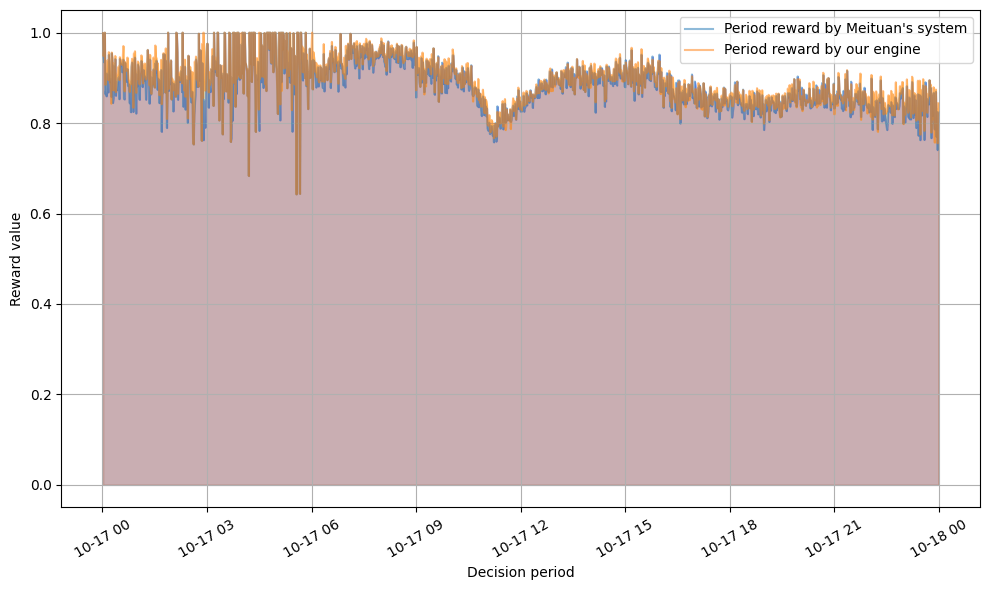

In [18]:
merged_df['original_period_reward'] = pd.to_numeric(merged_df['original_period_reward'], errors='coerce')
merged_df['optimized_period_reward'] = pd.to_numeric(merged_df['optimized_period_reward'], errors='coerce')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(merged_df['dispatch_minute'], merged_df['original_period_reward'], label="Period reward by Meituan's system", alpha=0.5)
plt.plot(merged_df['dispatch_minute'], merged_df['optimized_period_reward'], label="Period reward by our engine", alpha=0.5)

# Fill the entire area below the Original Period Reward
plt.fill_between(merged_df['dispatch_minute'], 
                 merged_df['original_period_reward'], 
                 0,  # Extend down to the x-axis
                 color='blue', alpha=0.3)

# Fill the entire area below the Optimized Period Reward
plt.fill_between(merged_df['dispatch_minute'], 
                 merged_df['optimized_period_reward'], 
                 0,  # Extend down to the x-axis
                 color='orange', alpha=0.3)

# Customize plot
plt.xlabel('Decision period')
plt.ylabel('Reward value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=30)

# Show plot
plt.tight_layout()
plt.show()